### Описание работы:
В рамках настоящей домашней работы я попытаюсь обучить модель на "сентимент" датасете, в котором размечены депрессия, тревожность и другие заболевания исходя из сообщений, которые люди запостили в твиттере

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import re
import pymorphy3
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrpec\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Датасет:

Загружаем датасет

In [8]:
df = pd.read_csv("Combined Data.csv")
df = df[['statement','status']].copy()

In [9]:
stop_words = set(stopwords.words('english'))
morph = pymorphy3.MorphAnalyzer()

In [10]:
def clean_text(text):

    """
    Удаляем, знаки препинания, табы, абзацы, цифры, двойные пробелы. Приводим к нижнему регистру
    """
    sentences = list()
    for sentence in text:
        sentence = re.sub(r'[^\w\s]|I|V', ' ', sentence)
        sentence = re.sub(r'\s+',' ', sentence)
        sentence = sentence.lower()
        sentences.append(sentence)
    return sentences


def lemmatize_sentence(sentence):
    words = sentence.split()  # Разбиваем предложение на слова
    lemmas = []
    for word in words:
            parsed_word = morph.parse(word)[0]  # Анализируем слово
            lemma = parsed_word.normal_form  # Получаем лемму
            if lemma not in stop_words:
                lemmas.append(lemma)
    return ' '.join(lemmas)  # Собираем слова обратно в предложение

def total_slay(text):
     cleaned = clean_text(text)
     lemmatized_sentence = [lemmatize_sentence(sentence) for sentence in cleaned]
     return lemmatized_sentence

Анализ данных датасета

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 828.9+ KB


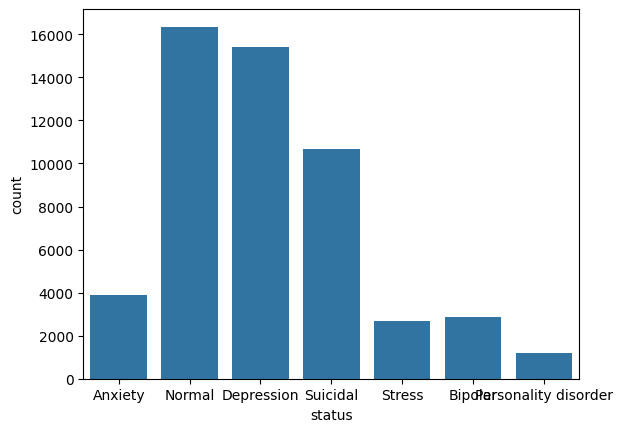

In [11]:
df.info()

sns.countplot(x='status', data=df)
plt.show()

Поскольку разброс между количеством классов большой я буду рассматривать только депрессию и норму.

#### Обработка датасета

In [12]:
# Удаляем заболевания
df_depr_norm = df[df['status'].isin(['Depression', 'Normal'])].reset_index(drop=True)
df_depr_norm['statement'] = df_depr_norm['statement'].astype(str)
texts = df_depr_norm['statement'].tolist()
statuses = df_depr_norm['status'].tolist()
df_depr_norm

,statement,status
0,"Gr gr dreaming of ex crush to be my game, God",Normal
1,wkwkwk what a joke,Normal
2,Leaves are also standby in front of the PC ......,Normal
3,Thank God even though it's just a ride through,Normal
4,wedding teaser concept using the song day6 - o...,Normal
...,...,...
31750,"solutions So, when I have my real bad downs th...",Depression
31751,I’m pretty sure I’m depressed.. Ive been feeli...,Depression
31752,I can’t be bothered anymore. I’m a 22 year old...,Depression
31753,Depression feels like you’re drowning and ther...,Depression


In [13]:
cleaned_texts = total_slay(texts)

In [14]:
for index, text in enumerate(cleaned_texts):
    if text == "":
        statuses.pop(index)
        cleaned_texts.pop(index)

In [15]:
len(cleaned_texts)

31599

In [16]:
len(statuses)

31599

In [ ]:
# Создаем токенизатор и обучаем на текстах
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_texts)
sequences = tokenizer.texts_to_sequences(cleaned_texts)

# Добиваем последовательности до одной длинны
padded_sequences = pad_sequences(sequences, padding='post')

Создадим финальный датафрейм с числовыми значениям

In [15]:
data = pd.DataFrame()
data['statements'] = list(padded_sequences)
data['status'] = list(statuses)
# Приводим категориальные данные в числовые
data['status'] = status = LabelEncoder().fit_transform(statuses)
data # 1 - Normal, 0 - Depression

,statements,status
0,"[9033, 9033, 2275, 480, 1586, 493, 291, 0, 0, ...",1
1,"[4406, 826, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1
2,"[1698, 56, 9908, 618, 1754, 1006, 280, 183, 0,...",1
3,"[300, 291, 7, 130, 1458, 0, 0, 0, 0, 0, 0, 0, ...",1
4,"[1971, 5342, 2681, 729, 1217, 15520, 852, 28, ...",1
...,...,...
31594,"[3073, 207, 51, 2803, 40, 1303, 359, 483, 297,...",0
31595,"[177, 142, 58, 34, 40, 157, 4, 12557, 124, 322...",0
31596,"[1554, 31, 1102, 39, 144, 950, 10, 1554, 120, ...",0
31597,"[14, 128, 1, 1610, 40, 1610, 235, 0, 0, 0, 0, ...",0


#### Переходим к обучению

In [16]:
# Делим на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, status, test_size=0.2, shuffle=False)
print(type(X_train))
print(X_train.shape)
print(type(y_train))
print(y_train.shape)

<class 'numpy.ndarray'>
(25279, 1845)
<class 'numpy.ndarray'>
(25279,)


In [17]:
print(len(tokenizer.word_index))

44055


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_4' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


790/790 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.6463 - loss: 2.8856 - val_accuracy: 0.7372 - val_loss: 2.8132 - learning_rate: 1.0000e-05
Epoch 2/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8101 - loss: 2.5194 - val_accuracy: 0.8081 - val_loss: 2.4969 - learning_rate: 1.0000e-05
Epoch 3/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8446 - loss: 2.3222 - val_accuracy: 0.8269 - val_loss: 2.2853 - learning_rate: 1.0000e-05
Epoch 4/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8533 - loss: 2.1582 - val_accuracy: 0.8201 - val_loss: 2.1378 - learning_rate: 1.0000e-05
Epoch 5/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8583 - loss: 1.9848 - val_accuracy: 0.8274 - val_loss: 1.9743 - learning_rate: 1.0000e-05
Epoch 6/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8534 - loss: 1.8252 - val_accuracy: 0.8367 - val_loss: 1.8035 - learning_rate: 1.0000e-05
Epoch 7/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accurac

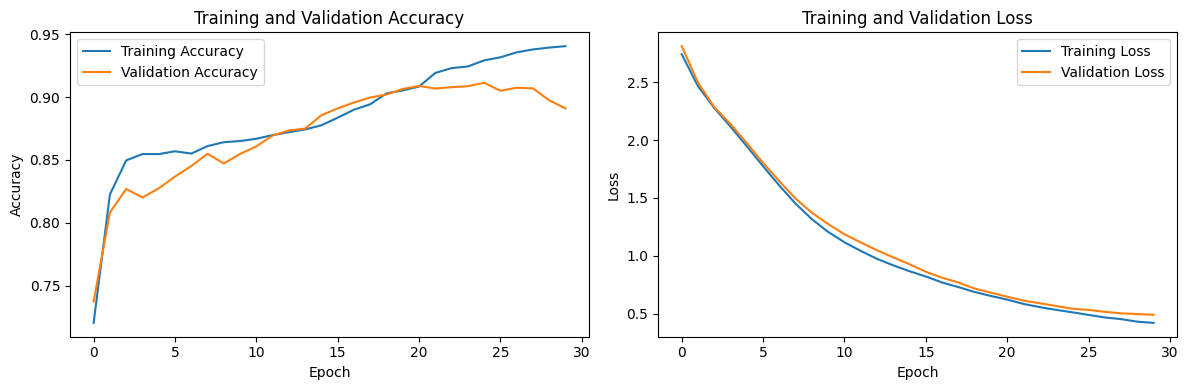

In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

model = Sequential([
    # Слой векторизации текста
    layers.Embedding(input_dim=44055, output_dim=64, mask_zero=True),

    # Первый сверточный слой
    layers.Conv1D(16, 3, activation='relu', kernel_regularizer=l2(0.02)),
    layers.MaxPooling1D(2),
    layers.Dropout(0.5),
    layers.BatchNormalization(),

    # Второй сверточный слой
    layers.Conv1D(32, 3, activation='relu', kernel_regularizer=l2(0.02)),
    layers.MaxPooling1D(2),
    layers.Dropout(0.5),
    layers.BatchNormalization(),

    # Плющим
    layers.Flatten(),

    # Полносвязный слой
    layers.Dense(32, activation='relu', kernel_regularizer=l2(0.02)),
    layers.Dropout(0.5),
    layers.BatchNormalization(),

    # Выходной слой
    layers.Dense(1, activation='sigmoid')
])

# Уменьшим начальную скорость обучения
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Добавляем EarlyStopping и ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)

history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])

# Оцениваем модель
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

# Отрисовка графика прогресса обучения
plt.figure(figsize=(12, 4))

# Отрисовка аккуратности (точности) модели
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Отрисовка значений функции потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


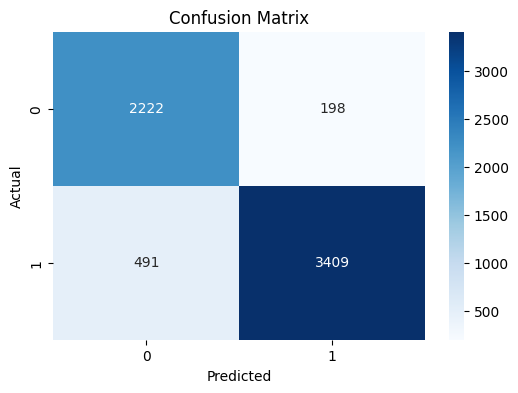


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      2420
           1       0.95      0.87      0.91      3900

    accuracy                           0.89      6320
   macro avg       0.88      0.90      0.89      6320
weighted avg       0.90      0.89      0.89      6320



In [43]:
# Получаем предсказания модели
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Строим confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
model.save("depression_twitter.keras")

In [ ]:
model = tf.keras.models.load_model(
    "depression_twitter.keras", custom_objects=None, compile=True, safe_mode=True
)

In [ ]:
def predict_category(text):
    # Препроцессинг
    text = lemmatize_sentence(text)
    sequences = tokenizer.texts_to_sequences([text])  # Передаем текст как список
    max_sequence_length = 1845  
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')
    
    # Предсказание
    prediction = model.predict(padded_sequences)
    
    # Усредняем

    mean_pred = np.mean(prediction, axis=0)  # Усредняем по временным шагам
    if mean_pred[0].round() == 1:
        print('Prediction: Normal')
    else:
        print('Prediction: Depression')

# Текстики от генерялок

text_depr_1 = '"Another day, another coffee. Funny how the sun keeps rising even when everything feels so heavy. But hey, at least the memes are still good, right? 🌥️☕ #JustAnotherDay'
text_depr_2 = "Me: exists Brain: Let’s overthink every life choice you’ve ever made at 2 a.m. Also me: Cool, cool, cool, totally fine. 🛌💭 #SleepIsForTheWeak"
text_norm_1 = "The sun is shining, the birds are chirping, and I’m just here vibing with my iced latte. Life’s good. 🌞✨ #GoodVibesOnly"
text_norm_2 = "When in doubt, add glitter. Or pizza. Or both. 🍕✨ #LifeHacks"

predict_category(text_depr_1)
predict_category(text_depr_2)
predict_category(text_norm_1)
predict_category(text_norm_2)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Prediction: Depression
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction: Depression
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Prediction: Normal


### Вывод: 
Нейросеть работает и показывает неплохие результаты на сгенеренных твитах со скрытой депрессией
### P.S.
Это было *сложно*. Попробую потом дообучить на больше классов